In [62]:
import itk
import matplotlib.pyplot as plt

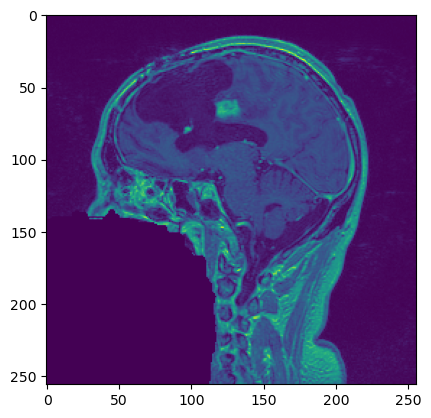

In [142]:
image = itk.imread("Data/case6_gre1.nrrd", itk.D)
plt.imshow(image[80])

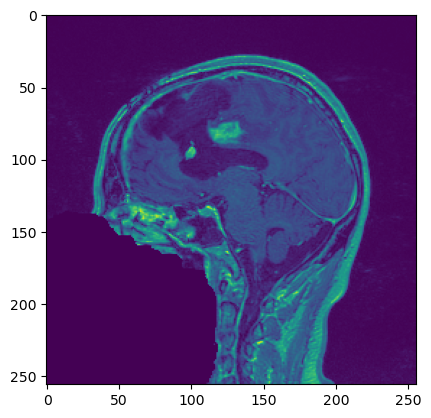

In [143]:
image2 = itk.imread("Data/case6_gre2.nrrd", itk.D)
plt.imshow(image2[80])

In [150]:
def RecalageRigide(fixed_image, moving_image):
    type_ = type(fixed_image)
    outType_ = itk.Image[itk.UC, 3]
    
    registration_method = itk.ImageRegistrationMethodv4[type_, type_].New()
    registration_method.SetFixedImage(fixed_image)
    registration_method.SetMovingImage(moving_image)
    
    transform_type = itk.TranslationTransform[itk.D, 3].New()
    transform_type.SetIdentity()
    registration_method.SetInitialTransform(transform_type)

    metric = itk.MeanSquaresImageToImageMetricv4[type_, type_].New()
    metric.SetFixedImage(fixed_image)
    metric.SetMovingImage(moving_image)

    interpolator = itk.BSplineInterpolateImageFunction[type_, itk.D, itk.D].New()
    interpolator.SetSplineOrder(3)
    metric.SetFixedInterpolator(interpolator)

    registration_method.SetMetric(metric)

    optimizer = itk.RegularStepGradientDescentOptimizerv4.New()
    optimizer.SetLearningRate(4.0)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(5)
    registration_method.SetOptimizer(optimizer)
    
    registration_method.Update()
    final_transform = registration_method.GetTransform()
    
    resampler = itk.ResampleImageFilter[type_, type_].New()
    resampler.SetInput(moving_image)
    resampler.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
    resampler.SetOutputOrigin(fixed_image.GetOrigin())
    resampler.SetOutputSpacing(fixed_image.GetSpacing())
    resampler.SetOutputDirection(fixed_image.GetDirection())
    resampler.SetTransform(final_transform)

    resampler.Update()
    resampled_image = resampler.GetOutput()

    cast_filter = itk.CastImageFilter[type_, outType_].New()
    cast_filter.SetInput(resampled_image)
    cast_filter.Update()
    return cast_filter.GetOutput()

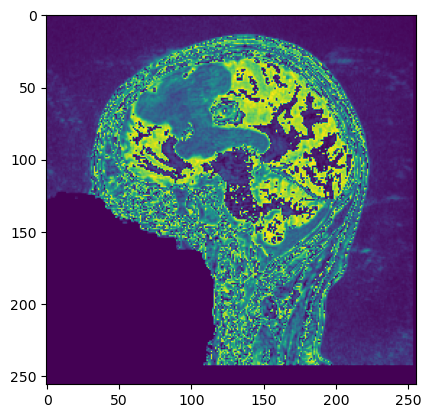

In [149]:
plt.imshow(RecalageRigide(image, image2)[80])